## Titanic: Machine Learning from Disaster

---

### Overview

This is an intro ML competition from Kaggle, described [here](https://www.kaggle.com/c/titanic).

Training data is [here](https://www.kaggle.com/c/titanic/download/train.csv) and validation data is [here](https://www.kaggle.com/c/titanic/download/test.csv).

#### Data Dictionary

Variable | Definition | Key
--- | --- | ---
survival | Survival | 0 = No, 1 = Yes
pclass | Ticket class | 1 = 1st, 2 = 2nd, 3 = 3rd
sex | Sex	
Age	| Age in years	
sibsp |	# of siblings / spouses aboard the Titanic	
parch | # of parents / children aboard the Titanic	
ticket | Ticket number	
fare | Passenger fare	
cabin | Cabin number	
embarked | Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton


#### Variable Notes

**pclass**: A proxy for socio-economic status (SES)
**1st** = Upper
**2nd** = Middle
**3rd** = Lower

**age**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

**sibsp**: The dataset defines family relations in this way...

*Sibling* = brother, sister, stepbrother, stepsister
*Spouse* = husband, wife (mistresses and fiancés were ignored)

**parch**: The dataset defines family relations in this way...

*Parent* = mother, father
*Child* = daughter, son, stepdaughter, stepson


### Solution

In [21]:
# start off by ensuring the test and training data have been downloaded.

import os
import tarfile
from six.moves import urllib
import os.path

TRAIN_FILE = "train.csv"
TEST_FILE = "test.csv"
LOCAL_DATA_PATH = './tmp/'

input_files = [TRAIN_FILE, TEST_FILE]
for file in input_files:
    if not os.path.isfile(LOCAL_DATA_PATH + file):
        raise ValueError('Missing file: ' + file)

In [22]:
# display the raw input training data
import pandas as pd

raw_train_df = pd.read_csv(LOCAL_DATA_PATH + TRAIN_FILE)
raw_test_df = pd.read_csv(LOCAL_DATA_PATH + TEST_FILE)
raw_train_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [23]:
raw_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [24]:
# stats of the numeric columns
raw_train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [25]:
# 891 rows of 12 columns
raw_train_df.shape

(891, 12)

In [26]:
# we can convert this to a boolean
raw_train_df['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [27]:
# this should be a categorical. there's no real value in the #
raw_train_df['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [28]:
# we might be able to extract some information based on title (mr., Mrs. etc.)
raw_train_df.head(5)['Name']

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [29]:
# we can convert this to a categorical
raw_train_df['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [30]:
# not sure there's any useful info in the ticket #s
raw_train_df['Ticket'].value_counts().head(5)

347082      7
CA. 2343    7
1601        7
CA 2144     6
3101295     6
Name: Ticket, dtype: int64

In [31]:
# we can identify those with multiple cabins (true/false)
# we can also extract deck and room # features
# in cases of multiple cabins, just pick the 'best' deck, aka. closest to A.
raw_train_df['Cabin'].value_counts().head(10)

C23 C25 C27    4
G6             4
B96 B98        4
F2             3
D              3
F33            3
E101           3
C22 C26        3
E8             2
B28            2
Name: Cabin, dtype: int64

In [32]:
# we can convert this to a categorical
raw_train_df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [33]:
# create a method to transform both the training set and the validation set
# will clean data and perform feature engineering here

# find best cabin if multiple cabins, and extract deck/room numbers
def get_cabin_details(raw_cabin):
    all_cabins = raw_cabin.split(' ')
    best_cabin = sorted(all_cabins)[0]
    
    deck = list(filter(lambda c: not c.isdigit(), best_cabin))[0]
    room_number = ''.join(list(filter(lambda c: c.isdigit(), best_cabin)))
    
    multiple_cabins = len(all_cabins) > 1
    
    return (deck, room_number, multiple_cabins)

def clean_df(raw_df):
    raw_df = raw_df.set_index('PassengerId')
    df = pd.DataFrame(index=raw_df.index)

    # convert survived (ground truth) to boolean column (doesn't exist in test set)
    if 'Survived' in df.columns:
        df['survived'] = raw_df['Survived'].astype('bool')
    
    # map passenger class to categories
    preference_map = {1: 'upper', 2: 'middle', 3: 'lower'}
    df['p_class'] = raw_df['Pclass'].map(preference_map).astype('category')
    
    # map sex to categories
    df['sex'] = raw_df['Sex'].astype('category')
    
    # copy age directly
    df['age'] = raw_df['Age']
    
    # copy sibling/spouse count directly
    df['sibling_spouse_count'] = raw_df['SibSp']
    
    # copy parent/child count directly
    df['parent_child_count'] = raw_df['Parch']
    
    # copy fare directly
    df['fare'] = raw_df['Fare']
    
    cabin_details = raw_df['Cabin'].dropna().apply(get_cabin_details)
    df['deck'] = cabin_details.apply(lambda x: x[0])
    df['room_number'] = cabin_details.apply(lambda x: x[1])
    df['multiple_cabins'] = cabin_details.apply(lambda x: x[2])
    
    # map passenger class to categories
    preference_map = {'C': 'cherbourg', 'Q': 'queenstown', 'S': 'southampton'}
    df['embarked_from'] = raw_df['Embarked'].map(preference_map).astype('category')

    return df

In [34]:
# clean up the training and test sets, then display some summary info on them.
cleaned_train_df = clean_df(raw_train_df)
cleaned_test_df = clean_df(raw_test_df)

In [39]:
cleaned_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 10 columns):
p_class                 891 non-null category
sex                     891 non-null category
age                     714 non-null float64
sibling_spouse_count    891 non-null int64
parent_child_count      891 non-null int64
fare                    891 non-null float64
deck                    204 non-null object
room_number             204 non-null object
multiple_cabins         204 non-null object
embarked_from           889 non-null category
dtypes: category(3), float64(2), int64(2), object(3)
memory usage: 58.4+ KB


In [40]:
cleaned_test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
p_class                 418 non-null category
sex                     418 non-null category
age                     332 non-null float64
sibling_spouse_count    418 non-null int64
parent_child_count      418 non-null int64
fare                    417 non-null float64
deck                    91 non-null object
room_number             91 non-null object
multiple_cabins         91 non-null object
embarked_from           418 non-null category
dtypes: category(3), float64(2), int64(2), object(3)
memory usage: 27.4+ KB


In [35]:
cleaned_train_df.tail()

,p_class,sex,age,sibling_spouse_count,parent_child_count,fare,deck,room_number,multiple_cabins,embarked_from
PassengerId,,,,,,,,,,
887,middle,male,27.0,0,0,13.00,NaN,NaN,NaN,southampton
888,upper,female,19.0,0,0,30.00,B,42,False,southampton
889,lower,female,NaN,1,2,23.45,NaN,NaN,NaN,southampton
890,upper,male,26.0,0,0,30.00,C,148,False,cherbourg
891,lower,male,32.0,0,0,7.75,NaN,NaN,NaN,queenstown


In [36]:
raw_train_df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [37]:
cleaned_test_df.tail()

,p_class,sex,age,sibling_spouse_count,parent_child_count,fare,deck,room_number,multiple_cabins,embarked_from
PassengerId,,,,,,,,,,
1305,lower,male,NaN,0,0,8.0500,NaN,NaN,NaN,southampton
1306,upper,female,39.0,0,0,108.9000,C,105,False,cherbourg
1307,lower,male,38.5,0,0,7.2500,NaN,NaN,NaN,southampton
1308,lower,male,NaN,0,0,8.0500,NaN,NaN,NaN,southampton
1309,lower,male,NaN,1,1,22.3583,NaN,NaN,NaN,cherbourg


In [38]:
raw_test_df.tail()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S
417,1309,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C


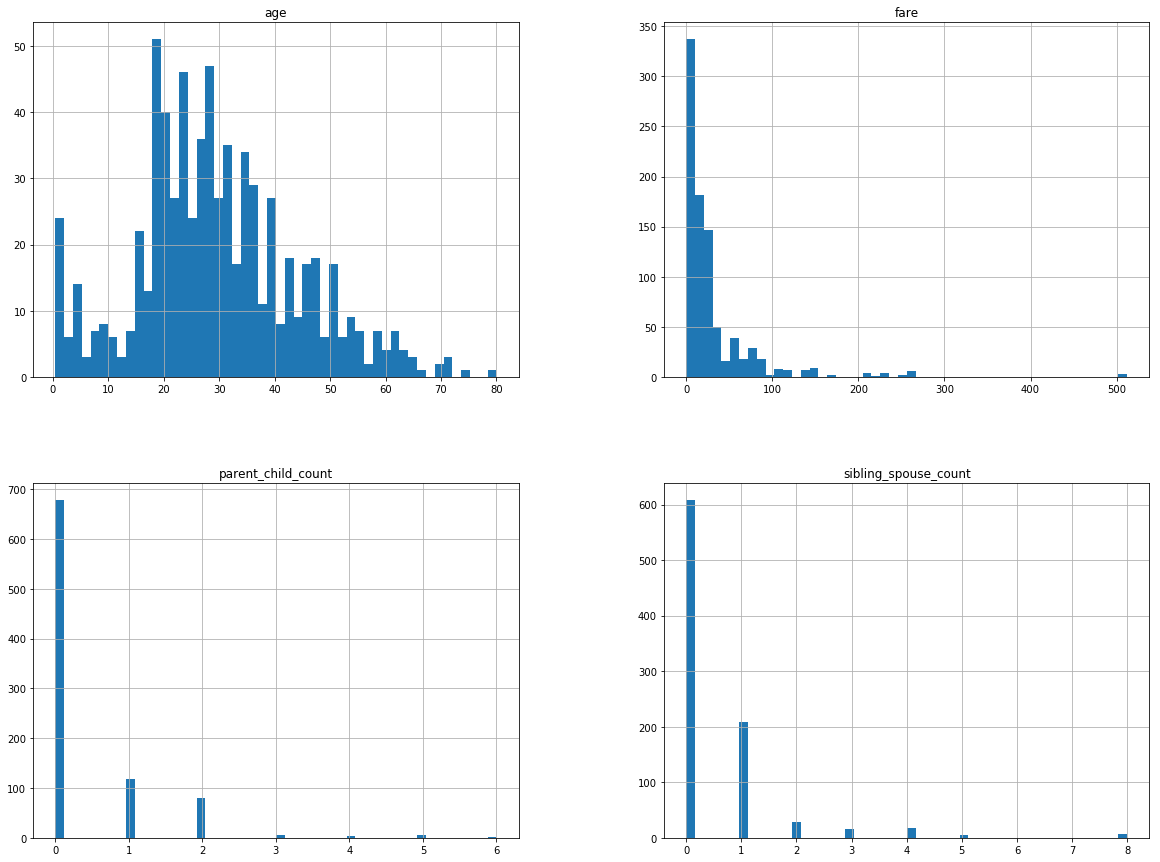

In [41]:
%matplotlib inline 
import matplotlib.pyplot as plt
cleaned_train_df.hist(bins=50, figsize=(20,15))
plt.show()